# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$
- \Delta u  + u = f, \text{ in } \Omega
$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

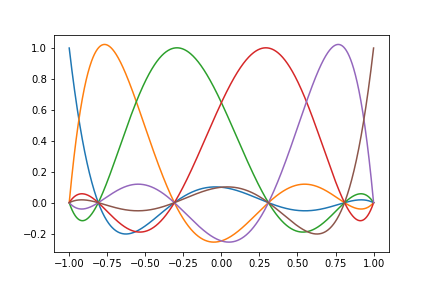

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

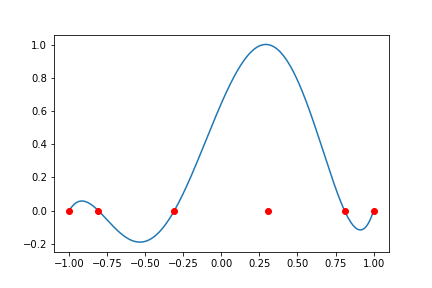

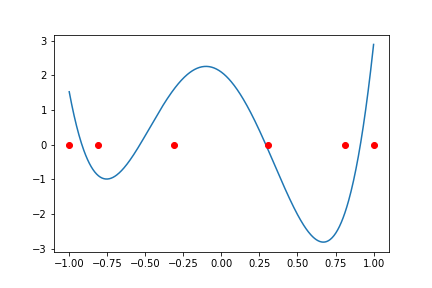

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [27]:
#%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
import time
from numba import jit, njit, prange, cuda

%store -r

In [3]:
def compute_one_dimensional_matrices(nipts, nqpts=None):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    #nqpts leggauss points integrate exactly polynomials of deg 2*nqpts+1
    #nipts interpolation points -> basis are deg nipts-1
    #so the bilinear form has deg 2*nipts-2
    #nqpts >= nipts-3/2 thus nqpts >= nipts-1
    #but, in the 2d case 
    if not nqpts:
        nqpts = nipts - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    D = np.empty((nipts, nqpts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        D[i, :] = np.polyder(ibasis)(qpts)
        
    M = np.einsum("iq, q, jq", B, qws, B)
    K = np.einsum("iq, q, jq", D, qws, D)
    
    return K, M, M + K

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [4]:
def exact_one_d(x):
    return np.cos(np.pi * x)
    
def rhs_one_d(x):
    return np.cos(np.pi * x) * (1.0 + np.pi ** 2)

def compute_error_one_d(n, exact, rhs):
    nipts = n
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = n - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    nqpts_err = 2 * nqpts
    qpts_err, qws_err = np.polynomial.legendre.leggauss(nqpts_err)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    Be = np.empty((nqpts_err, nipts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        Be[:, i] = ibasis(qpts_err)
    
    K, M, A = compute_one_dimensional_matrices(nipts)
    
    u = scipy.linalg.solve(A, B @ (rhs(qpts) * qws))
    
    return np.sqrt(np.sum(((exact(qpts_err) - (Be @ u))**2) * qws_err))

In [5]:
try:
    len(error_cos1d)
except NameError:
    error_cos1d = dict()

for n in range(10, 21):
    error_cos1d[n] = compute_error_one_d(n, exact_one_d, rhs_one_d)
%store error_cos1d

Stored 'error_cos1d' (dict)


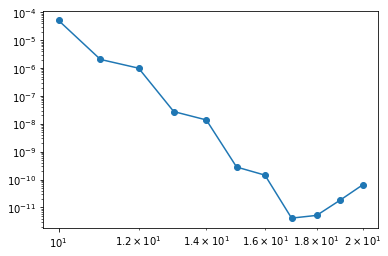

In [6]:
plt.loglog(error_cos1d.keys(), error_cos1d.values(), 'o-')

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [7]:
def compute_two_dimensional_matrices(nipts, nqpts=None):
    if not nqpts:
        nqpts = nipts
        
    K, M, A = compute_one_dimensional_matrices(nipts, nqpts)
    
    newshape = (nipts**2, nipts**2)
    
    KM = np.einsum("ik, jl -> ijkl", K, M)
    
    KK = KM + KM.T
    KK = KK.reshape(newshape)
    MM = np.einsum("ik, jl -> ijkl", M, M).reshape(newshape)
    
    return KK, MM, MM + KK

#compute_two_dimensional_matrices(20)

### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

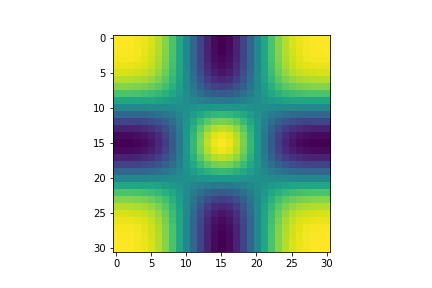

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [8]:
def exact_two_d(x):
    #return np.cos(np.pi * x[0, :]) * np.cos(np.pi * x[1, :])
    return np.prod(np.cos(np.pi * x), axis=0)
    
def rhs_two_d(x):
    return exact_two_d(x) * (1 + 2 * np.pi**2)

def compute_error_two_d(nipts, exact, rhs):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = nipts
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    nqpts_err = 2 * nqpts
    qpts_err, qws_err = np.polynomial.legendre.leggauss(nqpts_err)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    Be = np.empty((nqpts_err, nipts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        Be[:, i] = ibasis(qpts_err)
    
    BBe = np.einsum("ik, jl -> ijkl", Be, Be)
    BBe = BBe.reshape((nqpts_err**2, nipts**2))
    
    ipts2d = np.array(np.meshgrid(ipts, ipts), dtype=np.float64)
    ipts2d = ipts2d.reshape((2, nipts**2))
    
    KK, MM, AA = compute_two_dimensional_matrices(nipts, nqpts)
    
    qpts2d = np.array(np.meshgrid(qpts, qpts), dtype=np.float64)
    qpts2d = qpts2d.reshape((2, nqpts**2))
    
    ff = rhs(qpts2d).reshape((nqpts, nqpts))
    FF = np.einsum('iq, q, qp, p, jp-> ij', B, qws, ff, qws, B)
    
    uu = scipy.linalg.solve(AA, FF.reshape(nipts**2))
    
    qpts_err2d = np.array(np.meshgrid(qpts_err, qpts_err), dtype=np.float64)
    qpts_err2d = qpts_err2d.reshape((2, nqpts_err**2))
    
    qws_err2d = np.einsum('i, j -> ij', qws_err, qws_err)
    qws_err2d = qws_err2d.reshape((nqpts_err**2))
    
    return np.sqrt(np.sum(((exact(qpts_err2d) - (BBe @ uu))**2) * qws_err2d))

In [9]:
try:
    len(error_cos2d)
except NameError:
    error_cos2d = dict()

for n in range(10, 21):
    error_cos2d[n] = compute_error_two_d(n, exact_two_d, rhs_two_d)
%store error_cos2d

Stored 'error_cos2d' (dict)


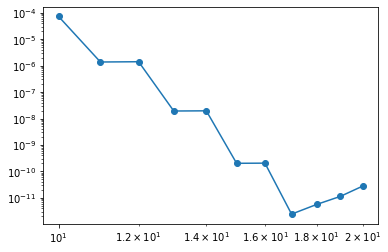

In [10]:
plt.loglog(error_cos2d.keys(), error_cos2d.values(), 'o-')

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [11]:
def matvec(src):
    return A.dot(src)

def cg(matvec, b, x0, tol=1e-05, maxiter=10000):
    # inside this function, you can call matvec(b) to evaluate the matrix vector 
    x = x0.copy()
    r = b - matvec(x)
    
    e = np.linalg.norm(r, 2)
    if e < tol:
        return x, 0, e
    
    p = r.copy()
    
    it = 1
    while it <= maxiter:
        Ap = matvec(p)
        a = p.dot(r) / p.dot(Ap)
        
        x += a * p
        r -= a * Ap
        
        e = np.linalg.norm(r, 2)
        if e < tol:
            break
        
        be = Ap.dot(r) / Ap.dot(p)
        p = r - be * p
            
        it += 1
    
    return x, it, e

def test_cg(nipts, exact, rhs):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = nipts - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)

    f = B @ (rhs(qpts) * qws)
    
    u = scipy.linalg.solve(A, f)
    u_cg, it, e = cg(matvec, f, np.zeros_like(f))
    e_cg = np.linalg.norm(u-u_cg, 2)
    print(f"finished in {it} iterations, diff {e_cg}, tolerance {e}")

In [12]:
nipts = 45
K, M, A = compute_one_dimensional_matrices(nipts)

print(f"cond(A): {np.linalg.cond(A)}")
try:
    np.linalg.cholesky(A)
    print("A is positive definite")
except np.linalg.LinAlgError:
    print("A is not positive definite")
    
test_cg(nipts, exact_one_d, rhs_one_d)

cond(A): 658853838925153.4
A is positive definite
finished in 10001 iterations, diff 35.40065506334376, tolerance 2.2279667166491937


### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [13]:
#@njit(parallel=True)
def matvec2_explicit(vinput):
    v = vinput.reshape((n, n))

    u = np.zeros_like(v)
    for i in prange(n):
        for j in range(n):
            for k in range(n):
                for l in range(n): 
                    t = K[i, k] * M[j, l] + M[i, k] * K[j, l] + M[i, k] * M[j, l]
                    u[i, j] += t * v[k, l]
    
    return u.reshape((n**2))

def matvec2(vinput):
    v = vinput.reshape((n, n))

    """
    Mv = M.dot(v) 
    Kv = K.dot(v)
    u = K.dot(Mv) + M.dot(Kv) + M.dot(Mv)
    """
    
    vM = v @ M
    #u = K @ vM + M @ v @ K + M @ vM
    u = (K + M) @ vM + M @ v @ K
    
    return u.reshape((n**2))

In [14]:
ns = [i for i in range(50, 101, 5)]
nrepeats = 10
 
t_matbuild2_1d = dict()
t_matbuild2_2d = dict()

t_matmul2 = dict()
t_matfree2 = dict()
##t_explicit = dict()

e_matfree2 = dict()
e_explicit2 = dict()

for n in ns:
    print(f"n: {n}")
    
    t = -time.perf_counter()
    K, M, A = compute_one_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild2_1d[n] = t
    
    newshape = (n**2, n**2)
    
    t = -time.perf_counter()
    KK, MM, AA = compute_two_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild2_2d[n] = t
    
    vinput = np.ones(n**2)
    
    print(f"matmul started")
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matmul = AA @ vinput
    t += time.perf_counter()
    t_matmul2[n] = t/nrepeats
    
    print(f"matfree started")
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matfree = matvec2(vinput)
    t += time.perf_counter()
    t_matfree2[n] = t/nrepeats
    e_matfree2[n] = np.linalg.norm(w_matmul-w_matfree, 2)
    
    """
    print(f"explicit started")
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_explicit = matvec2_explicit(vinput)
    t += time.perf_counter()
    t_explicit2[n] = t/nrepeats
    e_explicit2[n] = np.linalg.norm(w_matmul-w_explicit, 2)
    """
    
    #print(f"n {n} matfree diff {np.linalg.norm(w_matmul-w_matfree, 2)}")
    #print(f"n {n} explicit diff {np.linalg.norm(w_matmul-w_explicit, 2)}")
    
    print(f"cooldown")
    time.sleep(2)
    
%store t_matbuild2_1d
%store t_matbuild2_2d

%store t_matmul2
%store t_matfree2
#%store t_explicit

%store e_matfree2
#%store e_explicit2

n: 50
matmul started
matfree started
cooldown
n: 55
matmul started
matfree started
cooldown
n: 60
matmul started
matfree started
cooldown
n: 65
matmul started
matfree started
cooldown
n: 70
matmul started
matfree started
cooldown
n: 75
matmul started
matfree started
cooldown
n: 80
matmul started
matfree started
cooldown
n: 85
matmul started
matfree started
cooldown
n: 90
matmul started
matfree started
cooldown
n: 95
matmul started
matfree started
cooldown
n: 100
matmul started
matfree started
cooldown
Stored 't_matbuild2_1d' (dict)
Stored 't_matbuild2_2d' (dict)
Stored 't_matmul2' (dict)
Stored 't_matfree2' (dict)
Stored 'e_matfree2' (dict)


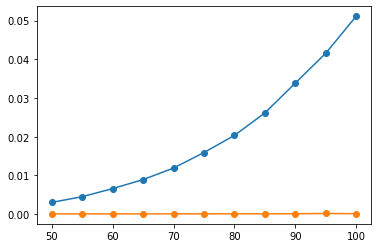

In [15]:
plt.plot(t_matmul2.keys(), t_matmul2.values(), "o-", label="matmul")
plt.plot(t_matfree2.keys(), t_matfree2.values(), "o-", label="matfree")

#_ = plt.plot(t_explicit2.keys(), t_explicit2.values(), "o-")

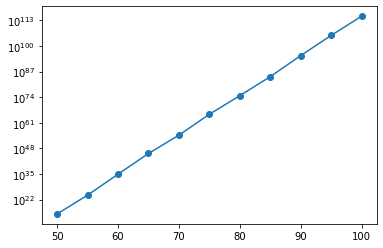

In [17]:
#norm of difference with full-matrix product result
plt.semilogy(e_matfree2.keys(), e_matfree2.values(), "o-", scaley="log", label="matfree")

#matrix build times
#plt.plot(t_matbuild2_1d.keys(), t_matbuild2_1d.values(), "o-")
#plt.plot(t_matbuild2_2d.keys(), t_matbuild2_2d.values(), "o-")

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.

In [42]:
def compute_three_dimensional_matrices(nipts, nqpts=None):
    if not nqpts:
        nqpts = nipts
        
    K, M, A = compute_one_dimensional_matrices(nipts, nqpts)
    
    newshape = (nipts**3, nipts**3)
    
    KMM = np.einsum('il, jm, kn -> ijklmn', K, M, M).reshape(newshape)
    MKM = np.einsum('il, jm, kn -> ijklmn', M, K, M).reshape(newshape)
    MMK = np.einsum('il, jm, kn -> ijklmn', M, M, K).reshape(newshape)
    
    print(f"KMM close to MMK.T? {np.allclose(KMM, MMK.T)}")
    
    KKK = KMM + MKM + MMK
    
    MMM = np.einsum('il, jm, kn -> ijklmn', M, M, M).reshape(newshape)
    
    return KKK, MMM, MMM + KKK

def matvec3_vx(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    u = K.dot(M.dot(Mv))
    u += M.dot(K.dot(Mv)) 
    u += M.dot(M.dot(Kv))
    u += M.dot(M.dot(Mv))
    
    u1 = K @ M @ Mv
    u1 += M @ K @ Mv
    u1 += M @ M @ Kv
    u1 += M @ M @ Mv
    
    M2 = M @ M
    
    u2 = K @ M @ Mv
    u2 += M @ K @ Mv
    u2 += M2 @ Kv
    u2 += M2 @ Mv
    
    u3 = K @ M @ Mv
    u3 += M @ (K @ Mv + M @ M @ (Kv + Mv))
               
    print(f"u-u1 {np.linalg.norm((u-u1).reshape((n**3)), 2)}")
    print(f"u-u2 {np.linalg.norm((u-u2).reshape((n**3)), 2)}")
    print(f"u-u3 {np.linalg.norm((u-u3).reshape((n**3)), 2)}")
    
    return u.reshape((n**3))

def matvec3(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    M2 = M @ M
    
    u = K @ M @ Mv
    u += M @ K @ Mv
    u += M2 @ Kv
    u += M2 @ Mv
    
    return u.reshape((n**3))

def matvec3_v0(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    u = K.dot(M.dot(Mv))
    u += M.dot(K.dot(Mv)) 
    u += M.dot(M.dot(Kv))
    u += M.dot(M.dot(Mv))
    
    return u.reshape((n**3))

def matvec3_v1(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    u = K @ M @ Mv
    u += M @ K @ Mv
    u += M @ M @ Kv
    u += M @ M @ Mv
    
    return u.reshape((n**3))

def matvec3_v2(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    M2 = M @ M
    
    u = K @ M @ Mv
    u += M @ K @ Mv
    u += M2 @ Kv
    u += M2 @ Mv
    
    return u.reshape((n**3))

def matvec3_v3(vinput):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))

    Mv = M @ v
    Kv = K @ v
    
    M2 = M @ M
    
    u = K @ M @ Mv + M @ (K @ Mv + M @ M @ (Kv + Mv))
    
    return u.reshape((n**3))

@njit
def matvec3_np_exp(vinput, M, K):
    n = round(vinput.shape[0]**(1/3))
    newshape = (n, n, n)
    v = vinput.reshape((n, n, n))

    Mv = np.zeros_like(v)
    Kv = np.zeros_like(v)
    
    MMv = np.zeros_like(v)
    KMv = np.zeros_like(v)
    MKv = np.zeros_like(v)
    
    for k in range(n):
        for l in range(n):
            for m in range(n):
                #rightmost: X[k, n] * v[l, m, n] erase n
                #M, K symm
                Mv[k, l, m] = np.sum(M[k, :] * v[l, m, :])
                Kv[k, l, m] = np.sum(K[k, :] * v[l, m, :])
         
    for j in range(n):
        for k in range(n):
            for l in range(n):
                #: X[j, m] * Yv[k, l, m] erase m
                KMv[j, k, l] = K[j, :] @ Mv[k, l, :]
                MKv[j, k, l] = M[j, :] @ Kv[k, l, :]
                MMv[j, k, l] = M[j, :] @ Mv[k, l, :]
    
    u = np.zeros_like(v)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                #: X[i, l] * YYv[j, k, l] erase l
                u[i, j, k] += K[i, :] @ (MMv[j, k, :] + KMv[j, k, :] + MKv[j, k, :])
                u[i, j, k] += M[i, :] @ MMv[j, k, :]
    
    return u.reshape((n**3))

#no out of scope arguments!
@njit(parallel=True)
def matvec3_jit_exp(vinput, M, K):
    n = round(vinput.shape[0]**(1/3))
    newshape = (n, n, n)
    v = vinput.reshape((n, n, n))

    Mv = np.zeros_like(v)
    Kv = np.zeros_like(v)
    
    MMv = np.zeros_like(v)
    KMv = np.zeros_like(v)
    MKv = np.zeros_like(v)
    
    for k in prange(n):
        for l in range(n):
            for m in range(n):
                #rightmost: X[k, n] * v[l, m, n] erase n
                #M, K symm
                Mv[k, l, m] = np.sum(M[k, :] * v[l, m, :])
                Kv[k, l, m] = np.sum(K[k, :] * v[l, m, :])
         
    for j in prange(n):
        for k in range(n):
            for l in range(n):
                #: X[j, m] * Yv[k, l, m] erase m
                KMv[j, k, l] = K[j, :] @ Mv[k, l, :]
                MKv[j, k, l] = M[j, :] @ Kv[k, l, :]
                MMv[j, k, l] = M[j, :] @ Mv[k, l, :]
    
    u = np.zeros_like(v)
    for i in prange(n):
        for j in range(n):
            for k in range(n):
                #: X[i, l] * YYv[j, k, l] erase l
                u += K[i, :] @ (MMv[j, k, :] + KMv[j, k, :] + MKv[j, k, :])
                u += M[i, :] @ MMv[j, k, :]
                #u[i, j, k] += M[i, :] @ KMv[j, k, :]
                #u[i, j, k] += M[i, :] @ MKv[j, k, :]
                #u[i, j, k] += M[i, :] @ MMv[j, k, :]
                
                #u[i, j, k] += M[i, :] @ (KMv[j, k, :] + MKv[j, k, :] + MMv[j, k, :])
                
                #u[i, j, k] += np.sum(M[i, :] * (KM_MK_v[j, k, :] + MMv[j, k, :]))
        
    #return (KMMv + MKMv + MMKv + MMMv).reshape((n**3))
    
    return u.reshape((n**3))

@cuda.jit
def matvec3_cudakernel(v, u, M, K):
    N = v.shape[0] 
    #i = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    #j = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    #k = cuda.blockDim.z * cuda.blockIdx.z + cuda.threadIdx.z
    (i, j, k) =  numba.cuda.grid(3)
    
    if i < N and j < N and k < N:
        T = 0
        for l in range(N):
            for m in range(N):
                KM = K[i, l] * M[j, m]
                MK = M[i, l] * K[j, m]
                MM = M[i, l] * M[j, m]
                
                for n in range(N):  
                    t = (KM + MK) * M[k, n] + MM * (K[k, n] + M[k, n])
                    
                    T += t * v[l, m, n]
        u[i, j, k] = T
        
def matvec3_cuda(vinput, M, K):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))
    u = np.zeros_like(v)
    
    #hard limit is (usually) 1024 threads per block
    blockSize = 8
    #assume that n fits the maximum index for all three dimensions
    gridSize = n // blockSize
    if n % blockSize:
        gridSize += 1
    
    blockDim = (blockSize, blockSize, blockSize)
    gridDim = (gridSize, gridSize, gridSize)
    
    #numba 0.5 (in the conda distribution) is incompatible with current NVidia toolkit
    #matvec3_cudakernel[gridDim, blockDim](v, u, M, K)
    
    return u.reshape((n**3))

#"just" in time, but compile now
K, M, A = compute_one_dimensional_matrices(2)
vinput=np.ones((n**3))

#matvec3_np(vinput, M, K)
#matvec3_jit(vinput, M, K)
matvec3_cuda(vinput, M, K)

print("done")

done


In [43]:
ns = [i for i in range(10, 25, 1)]
nrepeats = 10

t_matbuild3_1d = dict()
t_matbuild3_3d = dict()

t_matmul3 = dict()
t_matfree3 = dict()
t_np3 = dict()
t_jit3 = dict()
t_cuda3 = dict()
##t_explicit3 = dict()

e_matfree3 = dict()
e_np3 = dict()
e_jit3 = dict()
e_cuda3 = dict()
#e_explicit3 = dict()

for n in ns:
    #hardcoded, otherwise I risk swapping; by skipping iter, at the end vars are stored anyway
    
    if n >= 23:
        continue
    print(f"n: {n}")
    
    t = -time.perf_counter()
    K, M, A = compute_one_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild3_1d[n] = t
    
    newshape = (n**3, n**3)
    
    t = -time.perf_counter()
    KKK, MMM, AAA = compute_three_dimensional_matrices(n)
    t += time.perf_counter()
    t_matbuild3_3d[n] = t
    
    #np.random.seed(123456)
    #vinput = np.random.random(n**2)
    vinput = np.ones(n**3)
    
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matmul = AAA @ vinput
    t += time.perf_counter()
    t_matmul3[n] = t/nrepeats
    
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matfree = matvec3(vinput)
    t += time.perf_counter()
    t_matfree3[n] = t/nrepeats
    e_matfree3[n] = np.linalg.norm(w_matmul-w_matfree, 2)
    
    #comparisons
    ws = [0]*4
    ws[0] = matvec3_v0(vinput)
    ws[1] = matvec3_v1(vinput)
    ws[2] = matvec3_v2(vinput)
    ws[3] = matvec3_v3(vinput)
    
    for i, wi in enumerate(ws[:-1]):
        for j, wj in enumerate(ws[i+1:]):
            print(f"diff w[{i}] w[{i+1+j}] {np.linalg.norm(wi-wj, 2)}")
            
    for i, wi in enumerate(ws[:-1]):
        print(f"diff w[{i}] {np.linalg.norm(wi-w_matmul, 2)}")
            
    #print(f"n {n} matfree diff {np.linalg.norm(w_matfree-w_matmul, 2)}")
            
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_np = matvec3_np(vinput, M, K)
    t += time.perf_counter()
    t_np3[n] = t/nrepeats
    e_np3[n] = np.linalg.norm(w_matmul-w_np, 2)
    
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_jit = matvec3_jit(vinput, M, K)
    t += time.perf_counter()
    t_jit3[n] = t/nrepeats
    e_jit3[n] = np.linalg.norm(w_matmul-w_jit, 2)
    
    """
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_cuda = matvec3_cuda(vinput)
    t += time.perf_counter()
    t_cuda3[n] = t/nrepeats
    e_cuda3[n] = np.linalg.norm(w_matmul-w_cuda, 2)
    """
    
    """
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_explicit3 = matvec_explicit3d(vinput)
    t += time.perf_counter()
    t_explicit3[n] = t/nrepeats
    """
    
    time.sleep(2)
    
%store t_matbuild3_1d
%store t_matbuild3_3d

%store t_matmul3
%store t_matfree3
%store t_np3
%store t_jit3
%store t_cuda3
#%store t_explicit3

%store e_matfree3
%store e_np3
%store e_jit3
%store e_cuda3
#%store e_explicit3

n: 10
KMM close to MMK.T? False
diff w[0] w[1] 4.98810527437626
diff w[0] w[2] 4.98810527437626
diff w[0] w[3] 4.786914549536872
diff w[1] w[2] 0.0
diff w[1] w[3] 0.48190138428445595
diff w[2] w[3] 0.48190138428445595
diff w[0] 8.142152268657822
diff w[1] 7.398313795500087
diff w[2] 7.398313795500087


ValueError: Failed in nopython mode pipeline (step: convert to parfors)
Use of reduction variable 'u' other than in a supported reduction function is not permitted.

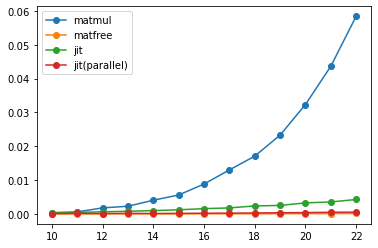

In [24]:
plt.plot(t_matmul3.keys(), t_matmul3.values(), "o-", label="matmul")
plt.plot(t_matfree3.keys(), t_matfree3.values(), "o-", label="matfree")
plt.plot(t_np3.keys(), t_np3.values(), "o-", label="jit")
plt.plot(t_jit3.keys(), t_jit3.values(), "o-", label="jit(parallel)")

plt.legend()

#_ = plt.plot(t_explicit2.keys(), t_explicit2.values(), "o-")
#_ = plt.plot(t_matbuild2_1d.keys(), t_matbuild2_1d.values(), "o-")
#_ = plt.plot(t_matbuild2_2d.keys(), t_matbuild2_2d.values(), "o-")

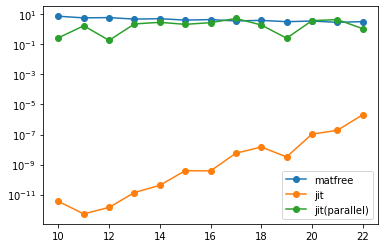

In [25]:
#norm of difference with full-matrix product result
plt.semilogy(e_matfree3.keys(), e_matfree3.values(), "o-", scaley="log", label="matfree")
plt.semilogy(e_np3.keys(), e_np3.values(), "o-", scaley="log", label="jit")
plt.semilogy(e_jit3.keys(), e_jit3.values(), "o-", scaley="log", label="jit(parallel)")

plt.legend()

#matrix build times
#plt.plot(t_matbuild2_1d.keys(), t_matbuild2_1d.values(), "o-")
#plt.plot(t_matbuild2_2d.keys(), t_matbuild2_2d.values(), "o-")